In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from time import time

In [2]:
device = torch.device("cpu")

In [3]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "raw-img")

In [4]:
fileToClass = {"cane": "dog", 
               "cavallo": "horse",
               "elefante": "elephant",
               "farfalla": "butterfly",
               "gallina": "chicken",
               "gatto": "cat",
               "mucca": "cow",
               "pecora": "sheep",
               "ragno": "spider",
               "scoiattolo": "squirrel"}

classToNumber = {"cane": 0,
                 "cavallo": 1,
                 "elefante": 2,
                 "farfalla": 3,
                 "gallina": 4,
                 "gatto": 5,
                 "mucca": 6,
                 "pecora": 7,
                 "ragno": 8,
                 "scoiattolo": 9}

numberToClass = {
                 0: "dog",
                 1: "horse",
                 2: "elephant",
                 3: "butterfly",
                 4: "chicken",
                 5: "cat",
                 6: "cow",
                 7: "sheep",
                 8: "spider",
                 9: "squirrel"
}

In [5]:
num_classes = len(fileToClass)
print(f"number of classes is : {num_classes}")

number of classes is : 10


In [6]:
model = models.vgg16(pretrained=True)

In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
model.classifier = nn.Sequential(*list(model.classifier.children())[:-3])

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
input_size = 224
tensor_transform = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor()])
    
dataset = ImageFolder(dataset_dir, tensor_transform)

imgPaths = dataset.imgs

In [11]:
print("sanity check")
counterDict = dict(Counter(dataset.targets))
print(counterDict)
print(f"number of class is : {len(counterDict)}")

noOfData = 0
for key in counterDict.keys():
    noOfData += counterDict[key]

print(f"total number of image is : {noOfData}")

sanity check
{0: 4863, 1: 2623, 2: 1446, 3: 2112, 4: 3098, 5: 1668, 6: 1866, 7: 1820, 8: 4821, 9: 1862}
number of class is : 10
total number of image is : 26179


In [12]:
loader = DataLoader(dataset=dataset, shuffle=True, num_workers=os.cpu_count())

N_CHANNELS = 3

before = time()
mean = torch.zeros(3)
std = torch.zeros(3)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(dataset))
std.div_(len(dataset))
print(mean, std)

print("time elapsed: ", time()-before)

==> Computing mean and std..


  0%|          | 0/26179 [00:00<?, ?it/s]

tensor([0.5177, 0.5003, 0.4126]) tensor([0.2135, 0.2130, 0.2151])
time elapsed:  401.4749870300293


In [13]:
trainPercentage = 0.8
testPercentage = 1 - trainPercentage

trainCounts = []
testCounts = []
for key in counterDict.keys():
    number = int(trainPercentage * counterDict[key])
    trainCounts.append(number)
    testCounts.append(counterDict[key] - number)

print(trainCounts)
print(testCounts)                                          

[3890, 2098, 1156, 1689, 2478, 1334, 1492, 1456, 3856, 1489]
[973, 525, 290, 423, 620, 334, 374, 364, 965, 373]


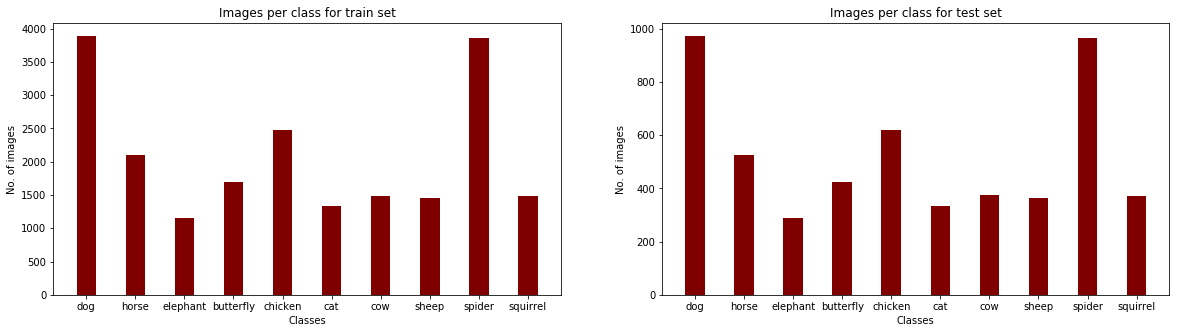

In [14]:
classes = [numberToClass[i] for i in range(num_classes)]

fig = plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
# creating the bar plot
plt.bar(classes, trainCounts, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of images")
plt.title("Images per class for train set")

plt.subplot(1, 2, 2)
plt.bar(classes, testCounts, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of images")
plt.title("Images per class for test set")

plt.show()

In [15]:
# trim from 2500 to make it more balanced.

newTrainCounts = []
newTestCounts = []
trimValue = 2500
for key in counterDict.keys():
    number = int(trainPercentage * counterDict[key])
    if number > trimValue:
        newTrainCounts.append(trimValue)
        newTestCounts.append(int(trimValue * (testPercentage / trainPercentage)))

    else:
        newTrainCounts.append(number)
        newTestCounts.append(counterDict[key] - number)

print(newTrainCounts)
print(newTestCounts)   

[2500, 2098, 1156, 1689, 2478, 1334, 1492, 1456, 2500, 1489]
[624, 525, 290, 423, 620, 334, 374, 364, 624, 373]


In [16]:
mean = [0.5177, 0.5003, 0.4126]
std = [0.2135, 0.2130, 0.2151]

tensor_transform = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean),
                                 torch.Tensor(std))])
    
dataset = ImageFolder(dataset_dir, tensor_transform)

loader = DataLoader(dataset=dataset, batch_size = 1, shuffle=False, num_workers=os.cpu_count())

In [17]:
data = np.empty(shape=[noOfData, 4096])
labels = np.empty(shape=[noOfData, 1])

with torch.no_grad():
    for i,(image, label) in enumerate(tqdm(loader)):
        output = model(image)
        data[i] = output.detach().numpy()    
        labels[i] = label
        

print(data.shape)
print(labels.shape)

  0%|          | 0/26179 [00:00<?, ?it/s]

(26179, 4096)
(26179, 1)


In [18]:
with open('data.npy', 'wb') as f:
    np.save(f, data)
    
with open('labels.npy', 'wb') as f:
    np.save(f, labels)

In [19]:
trainX = np.empty(shape=[sum(newTrainCounts), 4096])
trainY = np.empty(shape=[sum(newTrainCounts), 1])
testX = np.empty(shape=[sum(newTestCounts), 4096])
testY = np.empty(shape=[sum(newTestCounts), 1])

trainPaths = []
testPaths = []
pathIndex = 0

trainIndex = 0
testIndex = 0
numberOfTrainSamples = [0 for i in range(num_classes)]
numberOfTestSamples = [0 for i in range(num_classes)]

for i in range(len(data)):
    label = int(labels[i])
    if numberOfTrainSamples[label] == newTrainCounts[label]:
        if numberOfTestSamples[label] != newTestCounts[label]:
            testX[testIndex] = data[i]
            testY[testIndex] = labels[i]

            testIndex += 1
            
            numberOfTestSamples[label] += 1      
            
            testPaths.append(imgPaths[pathIndex][0])
            
    else:
        trainX[trainIndex] = data[i]
        trainY[trainIndex] = labels[i]
        
        trainIndex += 1
        
        numberOfTrainSamples[label] += 1
        
        trainPaths.append(imgPaths[pathIndex][0])
        
    
    pathIndex += 1

In [20]:
(uniqueTrain, countsTrain) = np.unique(trainY, return_counts=True)
print(f"frequency count of trainY {countsTrain}")
print(f"frequency count of wanted trainY {newTrainCounts}")
print("--------------")
(uniqueTest, countsTest) = np.unique(testY, return_counts=True)
print(f"frequency count of testy {countsTest}")
print(f"frequency count of wanted testY {newTestCounts}")

frequency count of trainY [2500 2098 1156 1689 2478 1334 1492 1456 2500 1489]
frequency count of wanted trainY [2500, 2098, 1156, 1689, 2478, 1334, 1492, 1456, 2500, 1489]
--------------
frequency count of testy [624 525 290 423 620 334 374 364 624 373]
frequency count of wanted testY [624, 525, 290, 423, 620, 334, 374, 364, 624, 373]


In [21]:
for i in range(len(countsTrain)):
    allData = countsTrain[i] + countsTest[i]
    print(f"distribution of class {i} - train : {countsTrain[i]/allData:.2f} , test : {countsTest[i]/allData:.2f}")

distribution of class 0 - train : 0.80 , test : 0.20
distribution of class 1 - train : 0.80 , test : 0.20
distribution of class 2 - train : 0.80 , test : 0.20
distribution of class 3 - train : 0.80 , test : 0.20
distribution of class 4 - train : 0.80 , test : 0.20
distribution of class 5 - train : 0.80 , test : 0.20
distribution of class 6 - train : 0.80 , test : 0.20
distribution of class 7 - train : 0.80 , test : 0.20
distribution of class 8 - train : 0.80 , test : 0.20
distribution of class 9 - train : 0.80 , test : 0.20


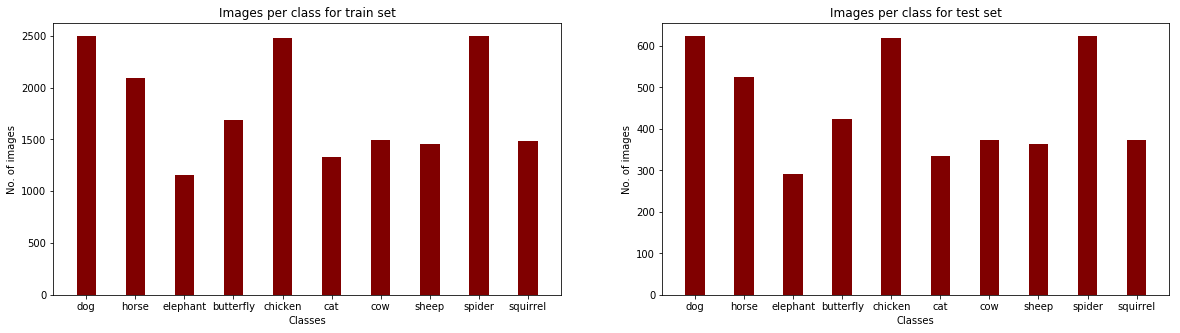

number of images in train set: 18192
number of images in test set: 4551


In [22]:
classes = [numberToClass[i] for i in range(num_classes)]

fig = plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
# creating the bar plot
plt.bar(classes, countsTrain, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of images")
plt.title("Images per class for train set")

plt.subplot(1, 2, 2)
plt.bar(classes, countsTest, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. of images")
plt.title("Images per class for test set")

plt.show()

print(f"number of images in train set: {trainX.shape[0]}")
print(f"number of images in test set: {testX.shape[0]}")

In [38]:
with open('trainX.npy', 'wb') as f:
    np.save(f, trainX)
    
with open('trainY.npy', 'wb') as f:
    np.save(f, trainY)
    
with open('testX.npy', 'wb') as f:
    np.save(f, testX)
    
with open('testY.npy', 'wb') as f:
    np.save(f, testY)
    
with open("testPaths.txt", "w") as f:
    for i in range(len(testPaths)):
        f.write(testPaths[i] + "\n")
        
with open("trainPaths.txt", "w") as f:
    for i in range(len(trainPaths)):
        f.write(trainPaths[i] + "\n")